In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.signal import savgol_filter
from matplotlib.ticker import FormatStrFormatter
import copy

In [2]:
folder_in = 'data_out'

'''defaults for plotting + some util fxns'''
fontsize_legend = 20
fontsize_axes = 24
fontsize_ticks = 16
linewidth_all = 3
markersize_all = 8
size_extra = 4

'''improve plot fxns'''
def improve_plot_multi(axis, xlabel = '', ylabel = '', ylim_top = None, ylim_bottom = None, xlim_left = None, xlim_right = None, sharex = False, sharey = False):
    if isinstance(axis, np.ndarray):
        #is a list, do list things
        if not isinstance(xlabel, list): xlabel = [xlabel] * len(axis)
        if not isinstance(ylabel, list): ylabel = [ylabel] * len(axis)
        if not isinstance(ylim_top, list): ylim_top = [ylim_top] * len(axis)
        if not isinstance(ylim_bottom, list): ylim_bottom = [ylim_bottom] * len(axis)
        if not isinstance(xlim_left, list): xlim_left = [xlim_left] * len(axis)
        if not isinstance(xlim_right, list): xlim_right = [xlim_right] * len(axis)

        for i in range(len(axis)):
            axis[i].tick_params(labelsize = fontsize_ticks)
        
        if axis[0].get_gridspec().ncols > 1:
            #single row, assuming set ylabel on [0] only unless sharey is False
            for i in range(len(axis)):
                if i == 0 or not sharey:
                    improve_plot(axis[i], xlabel = xlabel[i], ylabel = ylabel[i], ylim_top = ylim_top[i], ylim_bottom = ylim_bottom[i], xlim_left = xlim_left[i], xlim_right = xlim_right[i])
                else:
                    improve_plot(axis[i], xlabel = xlabel[i], xlim_left = xlim_left[i], xlim_right = xlim_right[i])
                    
        else:
            #single col
            for i in range(len(axis)):
                if i == len(axis)-1 or not sharex:
                    improve_plot(axis[i], xlabel = xlabel[i], ylabel = ylabel[i], ylim_top = ylim_top[i], ylim_bottom = ylim_bottom[i], xlim_left = xlim_left[i], xlim_right = xlim_right[i])
                else:
                    improve_plot(axis[i], ylabel = ylabel[i], ylim_top = ylim_top[i], ylim_bottom = ylim_bottom[i])
    else:
        #is just ax by itself
        improve_plot(axis, xlabel = xlabel, ylabel = ylabel, ylim_top = ylim_top, ylim_bottom = ylim_bottom, xlim_left = xlim_left, xlim_right = xlim_right)

def improve_plot(axis, xlabel = '', ylabel = '', ylim_top = None, ylim_bottom = None, xlim_left = None, xlim_right = None):
    #is just ax by itself
    axis.set_ylim(top = ylim_top, bottom = ylim_bottom)
    axis.set_xlim(left = xlim_left, right = xlim_right)
    axis.set_ylabel(ylabel, fontsize = fontsize_axes)
    axis.set_xlabel(xlabel, fontsize = fontsize_axes)
    axis.tick_params(labelsize = fontsize_ticks)

In [3]:
def find_pcr_n_alt(v_R, v_t):
    v1 = v_R
    v2 = v_t / v_R
    # print(f'({v1:.3f},{v2:.3f})')
    nu = 0.5

    n_all = [2,3,4,5,6]

    p_cr = lambda n: ((np.pi*v1)**2 + n**2)**2 * v2**3 / (12 * (1-nu**2) * n**2) + (np.pi*v1)**4 * v2/(n**2 * ((np.pi*v1)**2 + n**2)**2)

    p_cr_all = [p_cr(n) for n in n_all]
    idx_min = np.argmin(p_cr_all)
    return (n_all[idx_min], p_cr_all[idx_min])

def find_pcr_n(R,H,t):
    v_R = R/H
    v_t = t/H

    return find_pcr_n_alt(v_R = v_R, v_t = v_t)

def find_n(R,t,H):
    v_R = R/H
    v_t = t/H

    n, _ = find_pcr_n_alt(v_R, v_t)
    return n


def find_n_alt(v_R, v_t):
    n, _ = find_pcr_n_alt(v_R, v_t)
    return n


In [4]:
num_try_R = 400
num_try_t = 400
n_all = np.zeros((num_try_R, num_try_t), dtype = int)

res_all = np.zeros((num_try_R, num_try_t), dtype = int)
res_all_v2 = np.zeros((num_try_R, num_try_t), dtype = int)

v_R_try = np.linspace(0.1,0.6, num_try_R)
v_t_try = np.linspace(0.01,0.05, num_try_t)

for i,v_R in enumerate(v_R_try):
    for j,v_t in enumerate(v_t_try):
        res_all[i,j] = int(find_n_alt(v_R,v_t))

In [5]:
def calc_twist_onset(twist_deg):
    #return when twist crosses 5 deg
    twist_set = 5
    idx_gt_twist_set = next((i for i, val in enumerate(twist_deg) if np.abs(val) > twist_set), None)
    if idx_gt_twist_set is not None:
        return next(i for i, val in enumerate(twist_deg) if np.abs(val) > 0.5)
    else: return None

def calc_end_slope(vol_norm, twist_deg):
    #todo: this isn't really regressing anything maybe fix that?
    num_pts_select = 15

    end_idx = len(vol_norm)
    start_idx = end_idx - num_pts_select

    return np.abs(np.mean(np.diff(twist_deg[start_idx:end_idx])/np.diff(vol_norm[start_idx:end_idx])))

(-5.0, 0.0)

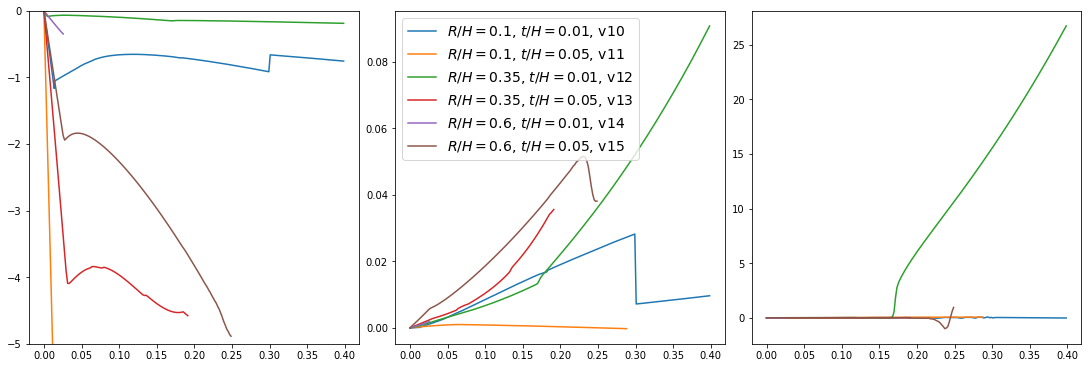

In [7]:
fig, ax = plt.subplots(1,3, figsize = (15,5), constrained_layout = True)
#props:
#[self.H, self.R, self.t1, self.t2, self.theta, self.w, self.E1, self.E2, self.E_cap, self.h_element]
idx_initial = 10
n1 = 3
n2 = 2
v1_sweep = np.linspace(0.1, 0.6, n1)
v2_sweep = np.linspace(0.01, 0.05, n2)

for i, v1 in enumerate(v1_sweep):
    for j, v2 in enumerate(v2_sweep):
        idx_try = idx_initial + i*len(v2_sweep) + j

        proj_name = f'geo_sweep_v{idx_try}'
        cvol, pcav = np.loadtxt(f'{folder_in}/{proj_name}_pcav_cvol.txt', unpack = True)
        time, contraction, twist = np.loadtxt(f'{folder_in}/{proj_name}_contraction_twist.txt', unpack = True)

        vol_norm = -(cvol - cvol[0]) / cvol[0]
        p_kpa = pcav * 1e3
        contraction_strain = 1 - contraction
        twist_deg = twist * 180 / np.pi

        ax[0].plot(vol_norm, p_kpa)
        ax[1].plot(vol_norm, contraction_strain, label = f'$R/H = {v1}$, $t/H = {v2}$, v{idx_try}')
        ax[2].plot(vol_norm, twist_deg)
    
ax[1].legend(loc = 'best', fontsize = 14)
ax[0].set_ylim(top = 0, bottom = -5)
            

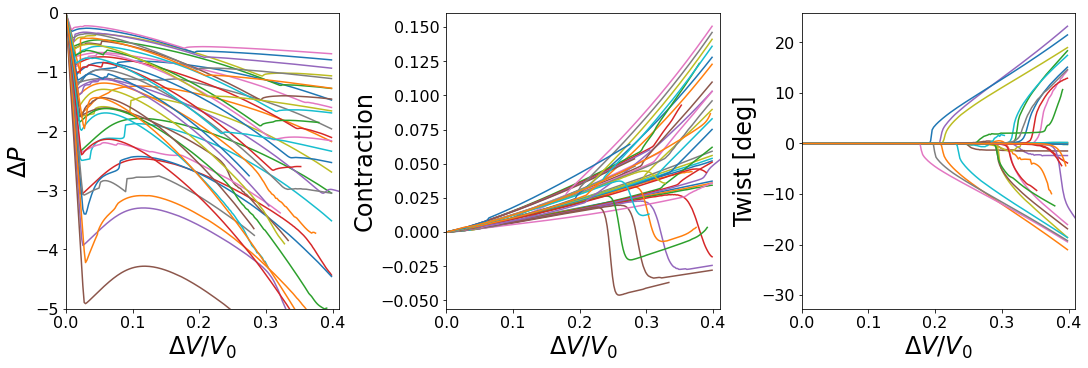

In [301]:
fig, ax = plt.subplots(1,3, figsize = (15,5), constrained_layout = True)
#props:
#[self.H, self.R, self.t1, self.t2, self.theta, self.w, self.E1, self.E2, self.E_cap, self.h_element]
idx_initial = 100
n1 = 7
n2 = 6
v1_sweep = np.linspace(0.2, 0.5, n1)
v2_sweep = np.linspace(0.02, 0.04, n2)

for i, v1 in enumerate(v1_sweep):
    for j, v2 in enumerate(v2_sweep):
        idx_try = idx_initial + i*len(v2_sweep) + j
        # print(idx_try)

        proj_name = f'geo_sweep_v{idx_try}'
        cvol, pcav = np.loadtxt(f'{folder_in}/{proj_name}_pcav_cvol.txt', unpack = True)
        time, contraction, twist = np.loadtxt(f'{folder_in}/{proj_name}_contraction_twist.txt', unpack = True)

        if len(contraction) != len(cvol):
            print(idx_try)
            print(len(contraction))
            print(len(cvol))
            print('-----')
        else:
            vol_norm = -(cvol - cvol[0]) / cvol[0]
            p_kpa = pcav * 1e3
            contraction_strain = 1 - contraction
            twist_deg = twist * 180 / np.pi

            ax[0].plot(vol_norm, p_kpa)
            ax[1].plot(vol_norm, contraction_strain, label = f'$R/H = {v1:.2f}$, $t/H = {v2:.2f}$, v{idx_try}')
            ax[2].plot(vol_norm, twist_deg)
    
# ax[1].legend(loc = 'best', fontsize = 14)
ax[0].set_ylim(top = 0, bottom = -5)
improve_plot_multi(ax, '$\Delta V/V_0$', ['$\Delta P$', 'Contraction', 'Twist [deg]'], xlim_left = 0, xlim_right = 0.41)

weird: 103
weird: 104
weird: 105
weird: 108
weird: 111
weird: 117
weird: 124
weird: 134


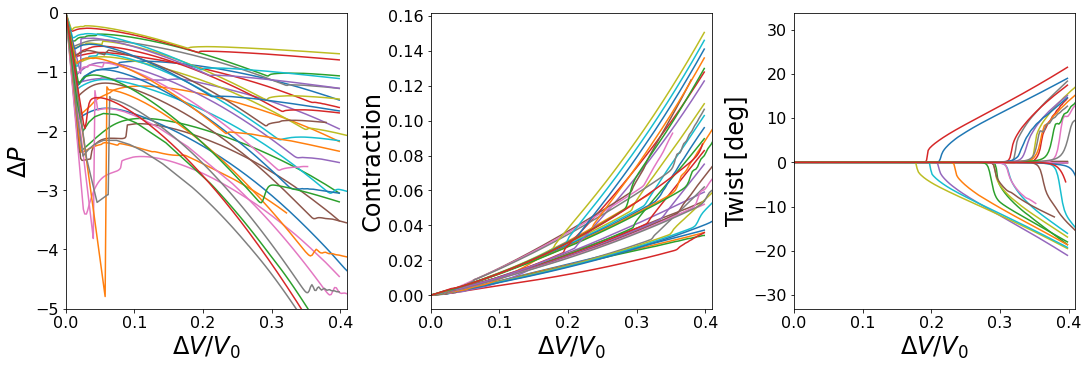

In [414]:
fig, ax = plt.subplots(1,3, figsize = (15,5), constrained_layout = True)
#props:
#[self.H, self.R, self.t1, self.t2, self.theta, self.w, self.E1, self.E2, self.E_cap, self.h_element]
idx_initial = 100
n1 = 7
n2 = 6
v1_sweep = np.linspace(0.2, 0.5, n1)
v2_sweep = np.linspace(0.02, 0.04, n2)

for i, v1 in enumerate(v1_sweep):
    for j, v2 in enumerate(v2_sweep):
        idx_try = idx_initial + i*len(v2_sweep) + j
        # print(idx_try)

        proj_name = f'geo_sweep_v{idx_try}'
        cvol, pcav = np.loadtxt(f'{folder_in}/{proj_name}_pcav_cvol.txt', unpack = True)
        time, contraction, twist = np.loadtxt(f'{folder_in}/{proj_name}_contraction_twist.txt', unpack = True)
        H, R, t1, _, _, w, _, _, _, _ = np.loadtxt(f'{folder_in}/{proj_name}_props.txt', unpack = True)
        if len(contraction) != len(cvol):
            print(idx_try)
            print(len(contraction))
            print(len(cvol))
            print('-----')
            continue
        vol_norm = -(cvol - cvol[0]) / cvol[0]
        p_kpa = pcav * 1e3
        contraction_strain = 1 - contraction
        twist_deg = twist * 180 / np.pi

        if np.min(np.diff(contraction_strain)) < 0:
            print(f'weird: {idx_try}')
            continue

        ax[0].plot(vol_norm, p_kpa)
        ax[1].plot(vol_norm, contraction_strain, label = f'$R/H = {v1:.2f}$, $t/H = {v2:.2f}$, v{idx_try}')
        ax[2].plot(vol_norm, twist_deg)
    
# ax[1].legend(loc = 'best', fontsize = 14)
ax[0].set_ylim(top = 0, bottom = -5)
improve_plot_multi(ax, '$\Delta V/V_0$', ['$\Delta P$', 'Contraction', 'Twist [deg]'], xlim_left = 0, xlim_right = 0.41)

fig.savefig('scream yi/twister_sweep_cleaned.png', facecolor = 'white')

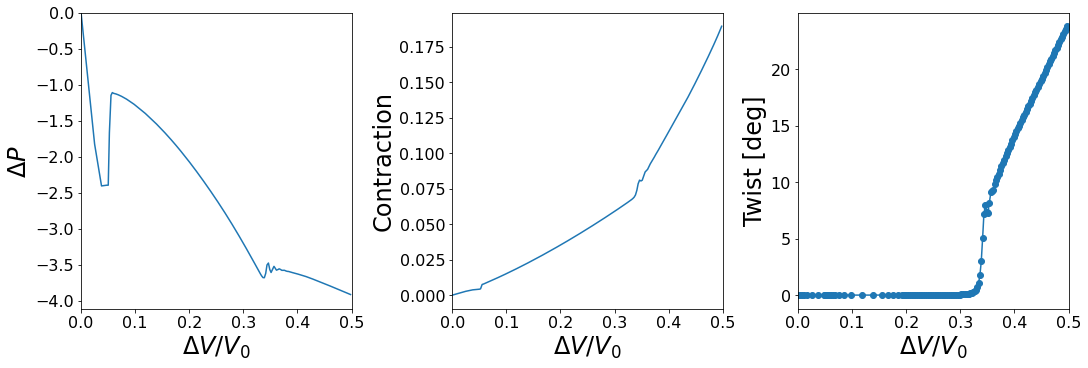

In [21]:
fig, ax = plt.subplots(1,3, figsize = (15,5), constrained_layout = True)

idx_try = 134

proj_name = f'geo_sweep_v{idx_try}'
cvol, pcav = np.loadtxt(f'{folder_in}/{proj_name}_pcav_cvol.txt', unpack = True)
time, contraction, twist = np.loadtxt(f'{folder_in}/{proj_name}_contraction_twist.txt', unpack = True)
H, R, t1, _, _, w, _, _, _, _ = np.loadtxt(f'{folder_in}/{proj_name}_props.txt', unpack = True)

vol_norm = -(cvol - cvol[0]) / cvol[0]
p_kpa = pcav * 1e3
contraction_strain = 1 - contraction
twist_deg = twist * 180 / np.pi


ax[0].plot(vol_norm, p_kpa)
ax[1].plot(vol_norm, contraction_strain, label = f'$R/H = {R/H:.2f}$, $t/H = {t1/H:.2f}$, v{idx_try}')
ax[2].plot(vol_norm, twist_deg, '-o')

ax[0].set_ylim(top = 0)
improve_plot_multi(ax, '$\Delta V/V_0$', ['$\Delta P$', 'Contraction', 'Twist [deg]'], xlim_left = 0, xlim_right = 0.5)


# np.diff(contraction_strain)
# fig.savefig(f'scream yi/old_geo_swep_v{idx_try}.png', dpi = 300, facecolor = 'white')

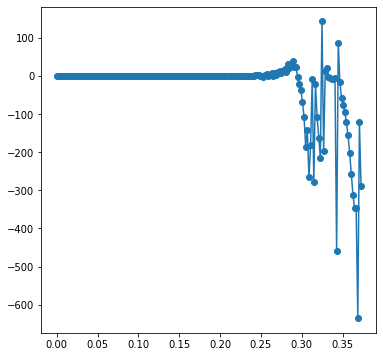

In [264]:
np.diff(twist_deg) / np.diff(vol_norm)

fig, ax = plt.subplots(figsize = (6,6))

ax.plot(vol_norm[:-1], np.diff(twist_deg) / np.diff(vol_norm), '-o')

In [10]:
'''calc vol onset all'''

def calc_vol_onset_all(remove_neg_cont = True, return_twist_slope = False, ignore_idx = None, return_pressure = False):
    idx_initial = 100
    n1 = 7
    n2 = 6
    v1_sweep = np.linspace(0.2, 0.5, n1)
    v2_sweep = np.linspace(0.02, 0.04, n2)

    vol_onset_all = np.empty((n1,n2))
    vol_onset_all[:] = np.nan
    twist_slope_all = np.zeros((n1,n2))

    pressure_onset_all = np.empty((n1,n2))
    pressure_onset_all[:] = np.nan

    for i, v1 in enumerate(v1_sweep):
        for j, v2 in enumerate(v2_sweep):
            idx_try = idx_initial + i*len(v2_sweep) + j
            vol_onset = np.nan
            pressure_onset = np.nan
            # print(idx_try)

            proj_name = f'geo_sweep_v{idx_try}'
            cvol, pcav = np.loadtxt(f'{folder_in}/{proj_name}_pcav_cvol.txt', unpack = True)
            time, contraction, twist = np.loadtxt(f'{folder_in}/{proj_name}_contraction_twist.txt', unpack = True)
            H, R, t1, _, _, w, E, _, _, _ = np.loadtxt(f'{folder_in}/{proj_name}_props.txt', unpack = True)
            if len(contraction) != len(cvol):
                continue
            vol_norm = -(cvol - cvol[0]) / cvol[0]
            p_kpa = pcav * 1e3
            contraction_strain = 1 - contraction
            twist_deg = twist * 180 / np.pi

            min_diff_cont_strain = np.min(np.diff(contraction_strain))

            if remove_neg_cont and  min_diff_cont_strain < 0 and np.abs(min_diff_cont_strain) > 0.005:
                continue

            if ignore_idx is not None:
                if any([idx_try == idx for idx in ignore_idx]): continue

            idx_onset = calc_twist_onset(twist_deg)
            if idx_onset is not None:
                vol_onset = vol_norm[idx_onset]
                pressure_onset = pcav[idx_onset] / E
                twist_slope_all[i,j] = calc_end_slope(vol_norm, twist_deg)

            vol_onset_all[i,j] = vol_onset
            pressure_onset_all[i,j] = pressure_onset
    if return_twist_slope:
        return (v1_sweep, v2_sweep, vol_onset_all, twist_slope_all)
    elif return_pressure:
        return (v1_sweep, v2_sweep, vol_onset_all, twist_slope_all, -pressure_onset_all)
    else: return (v1_sweep, v2_sweep, vol_onset_all)

[[       nan        nan        nan        nan        nan        nan]
 [0.3506485         nan        nan        nan        nan        nan]
 [0.32072545 0.34624222 0.37712365 0.38706843        nan        nan]
 [0.29483476 0.31279725 0.32884659 0.35417944 0.3766531  0.37408951]
 [0.20844108 0.29087721 0.30693116 0.32078349 0.34633005 0.35857431]
 [0.19325128 0.21189154 0.29094587 0.30684642 0.33153359 0.34067361]
 [0.17927974 0.19919951 0.2131433  0.23505504 0.31473443        nan]]


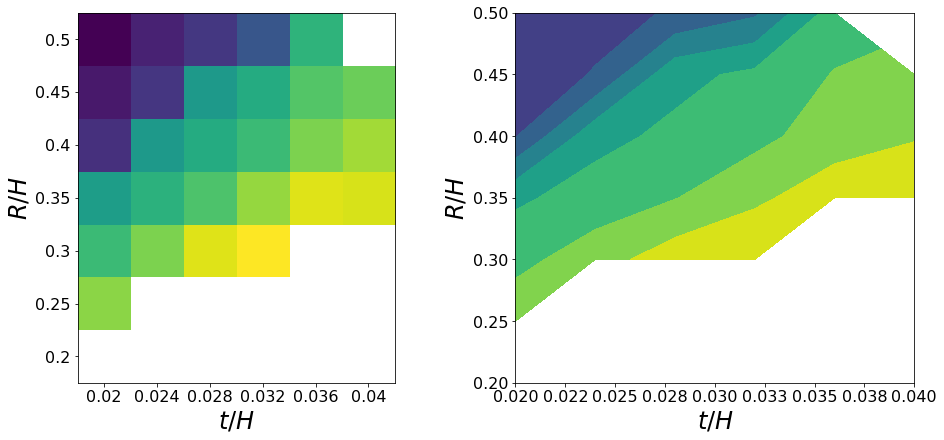

In [15]:
fig, ax = plt.subplots(1,2, figsize = (13,6), constrained_layout = True)

v1_sweep, v2_sweep, vol_onset_all = calc_vol_onset_all()

xv, yv = np.meshgrid(v1_sweep, v2_sweep, indexing='ij')
map_thing = ax[1].contourf(yv, xv, vol_onset_all)
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax[1].xaxis.set_major_formatter(FormatStrFormatter('%.3f'))

ax[0].imshow(vol_onset_all, origin = 'lower')
ax[0].set_xticks(np.arange(len(v2_sweep)), labels = v2_sweep.round(3))
ax[0].set_yticks(np.arange(len(v1_sweep)), labels = v1_sweep.round(2))

improve_plot_multi(ax, xlabel = '$t/H$', ylabel = '$R/H$')

# fig.savefig('scream yi/twister_sweep_cleaned.png', facecolor = 'white')
print(vol_onset_all)

[[       nan        nan        nan        nan        nan        nan]
 [0.3506485         nan        nan        nan        nan        nan]
 [0.32072545 0.34271146 0.37712365        nan        nan        nan]
 [0.29483476 0.31279725 0.31276874 0.29483072 0.26493551        nan]
 [0.20844108 0.29087721 0.30693116 0.32078349        nan        nan]
 [0.19325128 0.21189154 0.29094587 0.30684642        nan        nan]
 [0.17927974 0.19919951 0.2131433  0.23505504        nan        nan]]


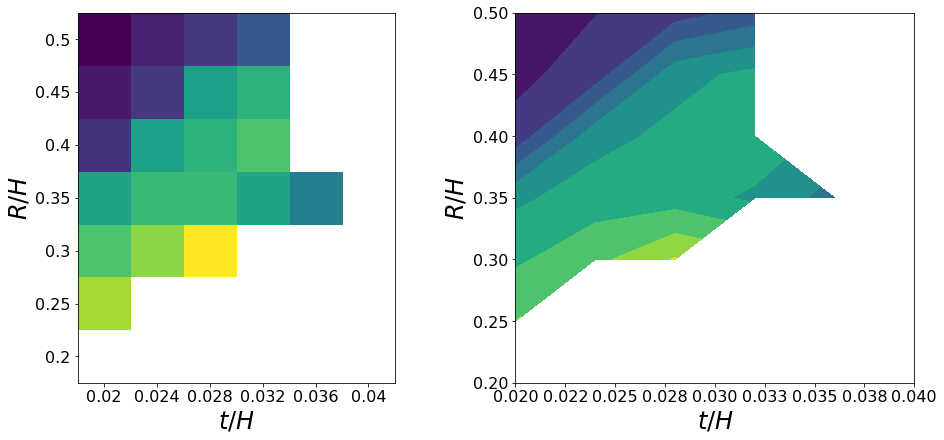

In [267]:
fig, ax = plt.subplots(1,2, figsize = (13,6), constrained_layout = True)

v1_sweep, v2_sweep, vol_onset_all = calc_vol_onset_all(remove_neg_cont = False)

xv, yv = np.meshgrid(v1_sweep, v2_sweep, indexing='ij')
map_thing = ax[1].contourf(yv, xv, vol_onset_all)
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax[1].xaxis.set_major_formatter(FormatStrFormatter('%.3f'))

ax[0].imshow(vol_onset_all, origin = 'lower')
ax[0].set_xticks(np.arange(len(v2_sweep)), labels = v2_sweep.round(3))
ax[0].set_yticks(np.arange(len(v1_sweep)), labels = v1_sweep.round(2))

improve_plot_multi(ax, xlabel = '$t/H$', ylabel = '$R/H$')
print(vol_onset_all)

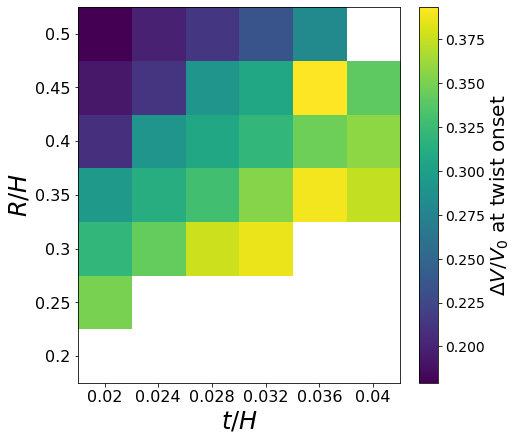

In [356]:
fig, ax = plt.subplots(figsize = (7,6), constrained_layout = True)

v1_sweep, v2_sweep, vol_onset_all = calc_vol_onset_all(remove_neg_cont = False)

map_thing = ax.imshow(vol_onset_all, origin = 'lower')
ax.set_xticks(np.arange(len(v2_sweep)), labels = v2_sweep.round(3))
ax.set_yticks(np.arange(len(v1_sweep)), labels = v1_sweep.round(2))

cbar = fig.colorbar(map_thing)
cbar.ax.tick_params(labelsize=14)
cbar.set_label('$\Delta V/V_0$ at twist onset', size = 20)

improve_plot_multi(ax, xlabel = '$t/H$', ylabel = '$R/H$')

fig.savefig('scream yi/vol_onset_none_removed.png', facecolor = 'white')

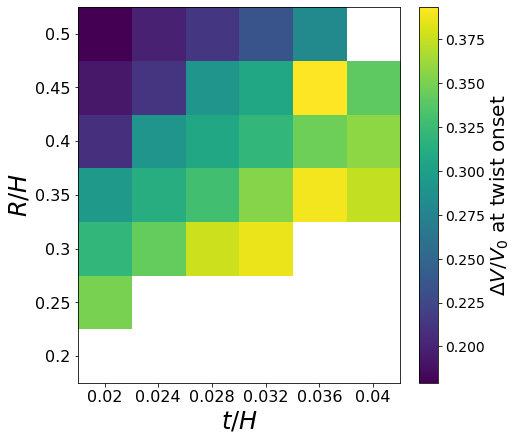

In [355]:
fig, ax = plt.subplots(figsize = (7,6), constrained_layout = True)

v1_sweep, v2_sweep, vol_onset_all = calc_vol_onset_all(remove_neg_cont = True)

map_thing = ax.imshow(vol_onset_all, origin = 'lower')
ax.set_xticks(np.arange(len(v2_sweep)), labels = v2_sweep.round(3))
ax.set_yticks(np.arange(len(v1_sweep)), labels = v1_sweep.round(2))

cbar = fig.colorbar(map_thing)
cbar.ax.tick_params(labelsize=14)
cbar.set_label('$\Delta V/V_0$ at twist onset', size = 20)

improve_plot_multi(ax, xlabel = '$t/H$', ylabel = '$R/H$')

fig.savefig('scream yi/vol_onset_some_removed.png', facecolor = 'white')

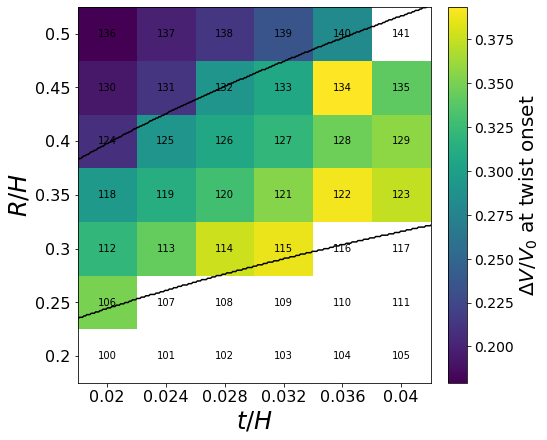

In [354]:
fig, ax = plt.subplots(figsize = (7.5,6), constrained_layout = True)

num_values = np.unique(res_all)
xv, yv = np.meshgrid(v_R_try, v_t_try, indexing='ij')
levels_set = np.arange(6) + 1.5


v1_sweep, v2_sweep, vol_onset_all = calc_vol_onset_all(remove_neg_cont = False)

dx = (v2_sweep[1]-v2_sweep[0])/2.
dy = (v1_sweep[1]-v1_sweep[0])/2.
extent = [v2_sweep[0]-dx, v2_sweep[-1]+dx, v1_sweep[0]-dy, v1_sweep[-1]+dy]

map_thing = ax.imshow(vol_onset_all, origin = 'lower', extent = extent, aspect = 'auto')

for i, v1 in enumerate(v1_sweep):
    for j, v2 in enumerate(v2_sweep):
        ax.text(v2, v1, f'{100 + i*len(v2_sweep)+j}', ha = 'center', va = 'center')

ax.set_xticks(v2_sweep, labels = v2_sweep.round(3))
ax.set_yticks(v1_sweep, labels = v1_sweep.round(2))

ylim_bottom, ylim_top = ax.get_ylim()
xlim_left, xlim_right = ax.get_xlim()

ax.contour(yv, xv, res_all, levels = levels_set, vmin = 2, vmax = 6, colors = 'k')

cbar = fig.colorbar(map_thing)
cbar.ax.tick_params(labelsize=14)
cbar.set_label('$\Delta V/V_0$ at twist onset', size = 20)



improve_plot_multi(ax, xlabel = '$t/H$', ylabel = '$R/H$', ylim_bottom = ylim_bottom, ylim_top = ylim_top, xlim_left = xlim_left, xlim_right = xlim_right)

fig.savefig('scream yi/vol_onset_none_removed_contour.png', facecolor = 'white')

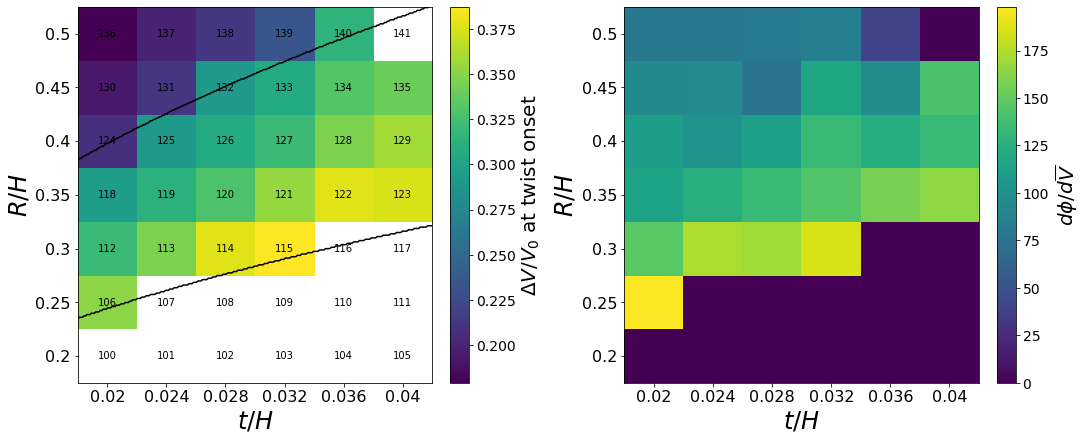

In [11]:
fig, ax = plt.subplots(1,2, figsize = (15,6), constrained_layout = True)

num_values = np.unique(res_all)
xv, yv = np.meshgrid(v_R_try, v_t_try, indexing='ij')
levels_set = np.arange(6) + 1.5


v1_sweep, v2_sweep, vol_onset_all, twist_slope_all = calc_vol_onset_all(remove_neg_cont = True, return_twist_slope = True)

dx = (v2_sweep[1]-v2_sweep[0])/2.
dy = (v1_sweep[1]-v1_sweep[0])/2.
extent = [v2_sweep[0]-dx, v2_sweep[-1]+dx, v1_sweep[0]-dy, v1_sweep[-1]+dy]

map_thing = ax[0].imshow(vol_onset_all, origin = 'lower', extent = extent, aspect = 'auto')
map_thing_twist = ax[1].imshow(twist_slope_all, origin = 'lower', extent = extent, aspect = 'auto')

for i, v1 in enumerate(v1_sweep):
    for j, v2 in enumerate(v2_sweep):
        ax[0].text(v2, v1, f'{100 + i*len(v2_sweep)+j}', ha = 'center', va = 'center')

for axis in ax:
    axis.set_xticks(v2_sweep, labels = v2_sweep.round(3))
    axis.set_yticks(v1_sweep, labels = v1_sweep.round(2))

ylim_bottom, ylim_top = ax[0].get_ylim()
xlim_left, xlim_right = ax[0].get_xlim()

ax[0].contour(yv, xv, res_all, levels = levels_set, vmin = 2, vmax = 6, colors = 'k')

cbar = fig.colorbar(map_thing)
cbar.ax.tick_params(labelsize=14)
cbar.set_label('$\Delta V/V_0$ at twist onset', size = 20)

cbar = fig.colorbar(map_thing_twist)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r'$d \phi / d \overline{V}$', size = 20)



improve_plot_multi(ax, xlabel = '$t/H$', ylabel = '$R/H$', ylim_bottom = ylim_bottom, ylim_top = ylim_top, xlim_left = xlim_left, xlim_right = xlim_right)

# fig.savefig('scream yi/vol_onset_none_removed_contour.png', facecolor = 'white')

0.4


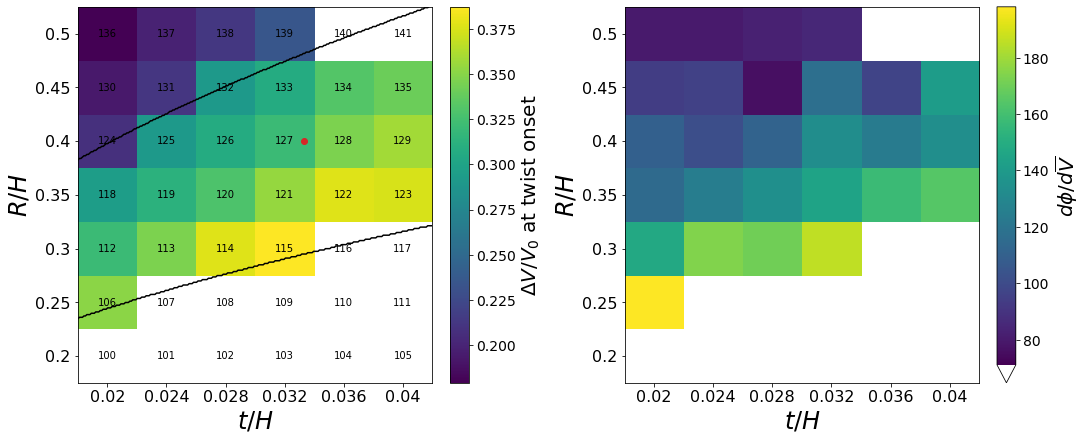

In [11]:
fig, ax = plt.subplots(1,2, figsize = (15,6), constrained_layout = True)

num_values = np.unique(res_all)
xv, yv = np.meshgrid(v_R_try, v_t_try, indexing='ij')
levels_set = np.arange(6) + 1.5


v1_sweep, v2_sweep, vol_onset_all, twist_slope_all = calc_vol_onset_all(remove_neg_cont = True, return_twist_slope = True, ignore_idx = [140, 141])
min_twist_slope = min(twist_val for twist_val in np.ndarray.flatten(twist_slope_all) if twist_val > 0)
cmap_twist_slope = copy.copy(plt.cm.viridis)
cmap_twist_slope.set_under('white')

dx = (v2_sweep[1]-v2_sweep[0])/2.
dy = (v1_sweep[1]-v1_sweep[0])/2.
extent = [v2_sweep[0]-dx, v2_sweep[-1]+dx, v1_sweep[0]-dy, v1_sweep[-1]+dy]

map_thing = ax[0].imshow(vol_onset_all, origin = 'lower', extent = extent, aspect = 'auto')
map_thing_twist = ax[1].imshow(twist_slope_all, origin = 'lower', extent = extent, aspect = 'auto', vmin = min_twist_slope - 5, cmap = cmap_twist_slope)

for i, v1 in enumerate(v1_sweep):
    for j, v2 in enumerate(v2_sweep):
        ax[0].text(v2, v1, f'{100 + i*len(v2_sweep)+j}', ha = 'center', va = 'center')

for axis in ax:
    axis.set_xticks(v2_sweep, labels = v2_sweep.round(3))
    axis.set_yticks(v1_sweep, labels = v1_sweep.round(2))

ylim_bottom, ylim_top = ax[0].get_ylim()
xlim_left, xlim_right = ax[0].get_xlim()

ax[0].contour(yv, xv, res_all, levels = levels_set, vmin = 2, vmax = 6, colors = 'k')



cbar = fig.colorbar(map_thing)
cbar.ax.tick_params(labelsize=14)
cbar.set_label('$\Delta V/V_0$ at twist onset', size = 20)

cbar = fig.colorbar(map_thing_twist, extend = 'min')
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r'$d \phi / d \overline{V}$', size = 20)

R_test = 18
H_test = 45
t_test = 1.5

print(R_test/H_test)
ax[0].plot(t_test/H_test, R_test/H_test, 'o', color = 'tab:red')

improve_plot_multi(ax, xlabel = '$t/H$', ylabel = '$R/H$', ylim_bottom = ylim_bottom, ylim_top = ylim_top, xlim_left = xlim_left, xlim_right = xlim_right)

# fig.savefig('figures_paper/twister_sweep_results.png', dpi = 300)
# fig.savefig('figures_paper/twister_sweep_results.pdf')

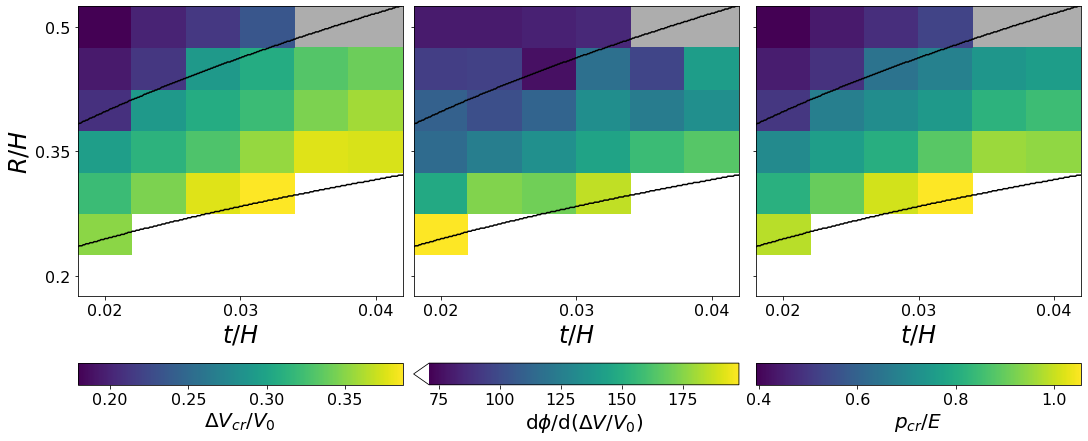

In [33]:
fig, ax = plt.subplots(1,3, figsize = (15,6), constrained_layout = True, sharey = True)

#notes:
#v2 == t/H sweep
#v1 == R/H sweep

'''analytical results'''
num_values = np.unique(res_all)
xv, yv = np.meshgrid(v_R_try, v_t_try, indexing='ij')
levels_set = np.arange(6) + 1.5

'''overlay for second nan region'''
overlay = np.empty((7,6))
overlay[:] = np.nan
overlay[6,4] = 0
overlay[6,5] = 0

'''pretend volume'''
H = 1
V_0_all = np.array([[(v_R*H)**2 * np.pi * H for v_R in v2_sweep] for v_t in v1_sweep])

'''numerical results'''
v1_sweep, v2_sweep, vol_onset_all, twist_slope_all, pressure_onset_all = calc_vol_onset_all(remove_neg_cont = True, return_pressure = True, ignore_idx = [140, 141])
min_twist_slope = min(twist_val for twist_val in np.ndarray.flatten(twist_slope_all) if twist_val > 0)
cmap_twist_slope = copy.copy(plt.cm.viridis)
cmap_twist_slope.set_under('white', alpha = 0)

X, Y=np.meshgrid(v2_sweep, v1_sweep)

dx = (v2_sweep[1]-v2_sweep[0])/2.
dy = (v1_sweep[1]-v1_sweep[0])/2.
extent = [v2_sweep[0]-dx, v2_sweep[-1]+dx, v1_sweep[0]-dy, v1_sweep[-1]+dy]

# ax[0].imshow(overlay, origin = 'lower', aspect = 'auto', extent = extent, cmap = 'Greys_r', vmin = -2, vmax = 1.5)
# ax[1].imshow(overlay, origin = 'lower', aspect = 'auto', extent = extent, cmap = 'Greys_r', vmin = -2, vmax = 1.5)

ax[0].pcolor(X, Y, overlay, cmap = 'Greys_r', vmin = -2, vmax = 1.5)
ax[1].pcolor(X, Y, overlay, cmap = 'Greys_r', vmin = -2, vmax = 1.5)
ax[2].pcolor(X, Y, overlay, cmap = 'Greys_r', vmin = -2, vmax = 1.5)

map_thing = ax[0].pcolor(X, Y, vol_onset_all)
map_thing_twist = ax[1].pcolor(X, Y, twist_slope_all, cmap = cmap_twist_slope, vmin = min_twist_slope - 5)
map_thing_pres = ax[2].pcolor(X, Y, pressure_onset_all)
# map_thing = ax[0].imshow(vol_onset_all, origin = 'lower', extent = extent, aspect = 'auto')
# map_thing_twist = ax[1].imshow(twist_slope_all, origin = 'lower', extent = extent, aspect = 'auto', vmin = min_twist_slope - 5, cmap = cmap_twist_slope)

# for i, v1 in enumerate(v1_sweep):
#     for j, v2 in enumerate(v2_sweep):
#         ax[0].text(v2, v1, f'{100 + i*len(v2_sweep)+j}', ha = 'center', va = 'center')

v2_sweep_label = np.array([v2_sweep[0], (v2_sweep[0] + v2_sweep[-1])/2, v2_sweep[-1]])
v1_sweep_label = np.array([v1_sweep[0], v1_sweep[3], v1_sweep[-1]])
for axis in ax:
    axis.set_xticks(v2_sweep_label, labels = v2_sweep_label.round(3))
    axis.set_yticks(v1_sweep_label, labels = v1_sweep_label.round(2))

ylim_bottom, ylim_top = ax[0].get_ylim()
xlim_left, xlim_right = ax[0].get_xlim()

ax[0].contour(yv, xv, res_all, levels = levels_set, vmin = 2, vmax = 6, colors = 'k')
ax[1].contour(yv, xv, res_all, levels = levels_set, vmin = 2, vmax = 6, colors = 'k')
ax[2].contour(yv, xv, res_all, levels = levels_set, vmin = 2, vmax = 6, colors = 'k')



cbar = fig.colorbar(map_thing, orientation = 'horizontal', aspect = 15)
cbar.ax.tick_params(labelsize=fontsize_ticks)
cbar.set_label('$\Delta V_{cr}/V_0$', size = fontsize_legend)

cbar = fig.colorbar(map_thing_twist, extend = 'min', orientation = 'horizontal', aspect = 15)
cbar.ax.tick_params(labelsize=fontsize_ticks)
cbar.set_label('$\mathrm{d} \phi / \mathrm{d} (\Delta V / V_0)$', size = fontsize_legend)

cbar = fig.colorbar(map_thing_pres, orientation = 'horizontal', aspect = 15)
cbar.ax.tick_params(labelsize=fontsize_ticks)
cbar.set_label('$p_{cr}/E$', size = fontsize_legend)


improve_plot_multi(ax, xlabel = '$t/H$', ylabel = '$R/H$', ylim_bottom = ylim_bottom, ylim_top = ylim_top, xlim_left = xlim_left, xlim_right = xlim_right, sharey = True)

# fig.savefig('scream yi/sweep_vol_twist_slope_pressure.png', dpi = 300, facecolor = 'white')

In [28]:
H = 1
V_0_all = np.array([[(v_R*H)**2 * np.pi * H for v_R in v2_sweep] for v_t in v1_sweep])
np.shape(V_0_all)

(7, 6)

In [382]:
min(twist_val for twist_val in np.ndarray.flatten(twist_slope_all) if twist_val > 0)

76.04904319879358

In [386]:
np.max(twist_slope_all)

198.0498746292844